In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import sys
sys.path.append('../')

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

from tqdm import tqdm

import torch

from src.config import DEVICE
from src.utils.parser import get_config
from src.unet.unet_train import get_dataloaders
from src.data.segmentation_dataset import SegmentationDataset
from src.contrastive.contrastive_unet_train import get_model

DATA_PATH = '../data/'
SIAMESE_PATH = f'{DATA_PATH}models/siamese/'

CONTRASTIVE_UNET_NAME = "contrastive_unet"

BATCH_SIZE = 1

In [28]:
# Get config parameters
config = get_config(f"../config/contrastive_unet_best_params.yml")
encoder_channels = config["encoder_channels"]
embedding_size = int(config["embedding_size"])
dropout_rate = float(config["dropout_rate"])

# Get model and load weights
siamese_model = get_model(
    encoder_channels=encoder_channels,
    embedding_size=embedding_size,
    dropout_rate=dropout_rate,
)

model_paths = sorted([l for l in os.listdir(SIAMESE_PATH) if CONTRASTIVE_UNET_NAME in l])
if len(model_paths) == 0:
    raise ValueError("❌ No pretrained model found.")

model_path = model_paths[-1]
model_path = f"{SIAMESE_PATH}{model_path}"
print(f"✅ Using model at {model_path}.")
siamese_model.load_state_dict(torch.load(model_path))

# Get encoder
encoder = siamese_model.branch.siamese_branch

# Get dataloaders
train_loader, val_loader, _ = get_dataloaders(
    batch_size=BATCH_SIZE,
    use_intact=True,    # To get half intact and half damaged data
    with_val=False,
    dataset_class=SegmentationDataset,
)

✅ Using model at ../data/models/siamese/20231227-020407_contrastive_unet.pth.
✅ Train dataloader length: 266
✅ Test dataloader length: 114


In [41]:
# Pass data through encoder
embeddings = []
labels = []
for i, (pre, post, _, label) in tqdm(enumerate(train_loader)):
    pre = pre.to(DEVICE)
    post = post.to(DEVICE)
    label = label.to(DEVICE)

    pair = torch.cat((pre, post), dim=1)

    with torch.no_grad():
        embedding = encoder(pair)

    embeddings.append(embedding)
    labels.append(label)

    if i == 100:
        break

embeddings = torch.cat(embeddings, dim=0)
labels = torch.cat(labels)

embeddings = embeddings.cpu().numpy()
labels = labels.cpu().numpy()

print(embeddings.shape, labels.shape)

100it [00:02, 36.43it/s]


(101, 128) (101,)


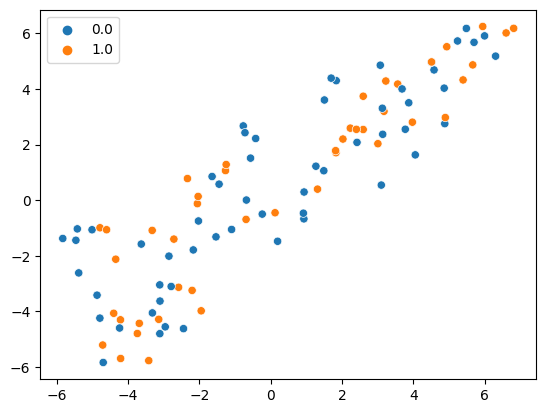

In [46]:
# Plot embeddings using t-sne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

tsne = TSNE(n_components=2, random_state=0)
tsne_embeddings = tsne.fit_transform(embeddings)

sns.scatterplot(
    x=tsne_embeddings[:, 0],
    y=tsne_embeddings[:, 1],
    hue=labels,
    legend="full",
    alpha=1.0,
)
plt.show()